In [1]:
!pip install openpyxl
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from datasets import load_dataset
data = load_dataset('ajgt_twitter_ar')

/home/magedsaeed/.virtualenvs/openai-evals/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset ajgt_twitter_ar (/home/magedsaeed/.cache/huggingface/datasets/ajgt_twitter_ar/plain_text/1.0.0/52248534d006e64154333ee6bb8bc3bea8545e00cfc156eaba190bf52dcff6b5)
100%|██████████| 1/1 [00:00<00:00, 114.09it/s]


In [2]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1800
    })
})

In [3]:
split_data = data['train'].train_test_split(test_size = 0.1, seed = 42)

Loading cached split indices for dataset at /home/magedsaeed/.cache/huggingface/datasets/ajgt_twitter_ar/plain_text/1.0.0/52248534d006e64154333ee6bb8bc3bea8545e00cfc156eaba190bf52dcff6b5/cache-24c8a8ed3b9ac255.arrow and /home/magedsaeed/.cache/huggingface/datasets/ajgt_twitter_ar/plain_text/1.0.0/52248534d006e64154333ee6bb8bc3bea8545e00cfc156eaba190bf52dcff6b5/cache-4b3df9fd7a19b083.arrow


In [4]:
split_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1620
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 180
    })
})

In [5]:
sys_msg = "Respond only positive or negative sentiment: "
def create_chat_prompt(sys_msg, input_text):
    return [
        {"role": "system", "content": sys_msg}, 
        {"role": "user", "content": input_text}
    ]

def create_chat_example(text, label):
    return [
        {"role": "system", "content": text, "name": "example_user"},
        {"role": "system", "content": ["negative", "positive"][label], "name": "example_assistant"},
    ]

In [6]:
!mkdir -p ../registry/data/classification

In [7]:
dev_df = split_data['train'].to_pandas()
dev_df["sample"] = dev_df.apply(lambda x: create_chat_example(x['text'], x['label']), axis=1)
dev_df[["sample"]].to_json('../registry/data/classification/few_shot.jsonl', lines=True, orient="records",force_ascii=False)

test_df = split_data['test'].to_pandas()
test_df["input"] = test_df['text'].apply(lambda x: create_chat_prompt(sys_msg, x))
test_df["ideal"] = test_df['label'].map({1:"positive", 0:"negative"})
test_df[["input", "ideal"]].to_json('../registry/data/classification/samples.jsonl', lines=True, orient="records",force_ascii=False)

In [8]:
import os
os.environ["OPENAI_API_KEY"] = "<openai-key>"
os.environ["EVALS_THREADS"]="1"
os.environ["EVALS_THREAD_TIMEOUT"]="600"

In [9]:
!ls ../../evals

api.py	 data.py   eval.py	  metrics.py   record.py    utils
base.py  datasets  formatting.py  prompt       registry
cli	 elsuite   __init__.py	  __pycache__  registry.py


In [10]:
!ls ../../evals/registry/data/classification/

few_shot.jsonl	samples.jsonl


In [11]:
# !oaieval gpt-3.5-turbo classification --max_samples 10
!oaieval gpt-3.5-turbo classification

[2023-04-14 06:51:15,287] [registry.py:156] Loading registry from /home/magedsaeed/MyProjects/evals/evals/registry/evals
[2023-04-14 06:51:15,417] [registry.py:156] Loading registry from /home/magedsaeed/.evals/evals
[2023-04-14 06:51:16,748] [oaieval.py:213] Run started: 230414035116KSSBYNMX
[2023-04-14 06:51:16,749] [data.py:75] Fetching classification/few_shot.jsonl
[2023-04-14 06:51:16,760] [data.py:75] Fetching classification/samples.jsonl
[2023-04-14 06:51:16,761] [eval.py:32] Evaluating 10 samples
[2023-04-14 06:51:16,764] [eval.py:152] Running in threaded mode with 1 threads!
 30%|█████████████▏                              | 3/10 [00:05<00:13,  1.87s/it][2023-04-14 06:51:23,354] [_common.py:105] Backing off openai_chat_completion_create_retrying(...) for 1.3s (openai.error.RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-gRO0WJ3ChMWZJMHenTPTkMJR on requests per min. Limit: 3 / min. Please try again in 20s. Contact support@openai.com if you conti

In [12]:
!ls /tmp/evallogs

2304140243363OVQSR2D_gpt-3.5-turbo_diacratization.jsonl
230414024512RVD45YOJ_gpt-3.5-turbo_diacratization.jsonl
230414024613L5UALWZF_gpt-3.5-turbo_diacratization.jsonl
230414024716Z4NTVN7Q_gpt-3.5-turbo_diacratization.jsonl
230414024827I2SHVQY6_gpt-3.5-turbo_diacratization.jsonl
2304140250553U2PV27S_gpt-3.5-turbo_diacratization.jsonl
230414025138YHOX5ZUI_gpt-3.5-turbo_diacratization.jsonl
230414025430TEZ6TLAS_gpt-3.5-turbo_diacratization.jsonl
230414025459Q56JRC7X_gpt-3.5-turbo_diacratization.jsonl
230414025613TO5AL4YL_gpt-3.5-turbo_diacratization.jsonl
230414032536PDEAGCMT_gpt-3.5-turbo_classification.jsonl
2304140334113Y5I7PMK_gpt-3.5-turbo_classification.jsonl
23041403345333YWRNQV_gpt-3.5-turbo_classification.jsonl
230414033900CXZPPNWF_gpt-3.5-turbo_classification.jsonl
230414035116KSSBYNMX_gpt-3.5-turbo_classification.jsonl


In [13]:
import pandas as pd
events = f"/tmp/evallogs/230414035116KSSBYNMX_gpt-3.5-turbo_classification.jsonl"

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)

In [14]:
events_df[events_df['final_report'].notnull()]['final_report']

1    {'accuracy': 0.9}
Name: final_report, dtype: object

<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

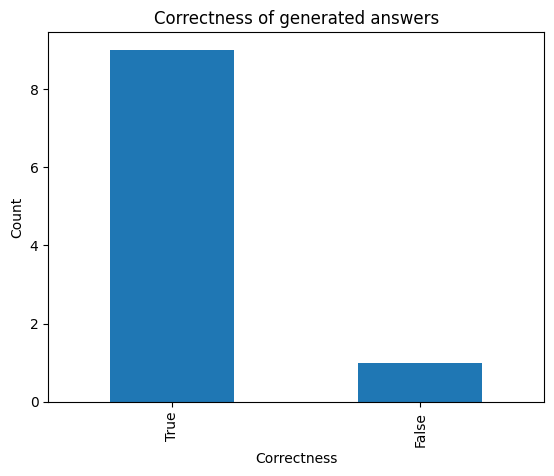

In [15]:
matches_df = events_df[events_df.type == "classification"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.accuracy.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [16]:
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt[-1]}")
    print(f"Sampled: {r.sampled}")
    print(f"{i}","--" * 25)

Prompt: {'role': 'user', 'content': 'كلام جميل الكرامه افضل ابقى للانسان'}
Sampled: positive
0 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'و اذا فادنا بشي رح يكون في خساره كبيره بالاخر'}
Sampled: negative
1 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'اللهم اكفني بحلالك عن حرامك واغنني بفضلك عمن سواك يا رب'}
Sampled: positive
2 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'شكرا دكتور فكلماتك لها بالغ الاثر في نفوسنا'}
Sampled: positive
3 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'ما شاء الله جميله جدا'}
Sampled: positive
4 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'لا استطيع اللهم ارزقنا العافيه وشكر نعمتك'}
Sampled: positive
5 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'كل البدايات جميله لكن العبره دائما تكون بالختام,اما كسبت 